# REPLIED VS DELETED INTERACTIONS

## Simple comparison between the pairs (user, item) that have had interaction 4 (deleted) versus interaction 3 (replied)

This notebook tries to get insights into why users delete job notifications and why they reply to job offers:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# Import all the interactions of type "delete"
folderData = 'data/'
deleted_interactions = pd.read_csv(folderData + 'interactions_deleted.csv')
deleted_interactions.head()

,user_id,item_id,interaction_type,created_at
0,321946,560,4,1484925131
1,1300778,560,4,1484302470
2,1555094,560,4,1484592137
3,61911,890,4,1484425678
4,856138,890,4,1483611369


In [3]:
# Import all the interactions of type "replied"
replied_interactions = pd.read_csv(folderData + 'interactions_replied.csv')
replied_interactions.head()

,user_id,item_id,interaction_type,created_at
0,518323,890,3,1483473392
1,472504,1190,3,1485419881
2,1790848,1830,3,1483950415
3,803720,1880,3,1483377509
4,803720,1880,3,1485860254


Do we have (user, item) pairs that are common between both groups?

In [4]:
intersection = pd.merge(deleted_interactions, replied_interactions, how='inner', on=['user_id', 'item_id'])

In [5]:
intersection.head()

,user_id,item_id,interaction_type_x,created_at_x,interaction_type_y,created_at_y
0,1546300,2250,4,1485947944,3,1485852205
1,1001738,114660,4,1483609630,3,1483605973
2,616377,115630,4,1483626681,3,1483611470
3,1907798,135370,4,1479040128,3,1479036526
4,627173,295530,4,1478848478,3,1479128428


Drop the intersections from deleted_interactions and replied_interactions

In [6]:
idx = deleted_interactions['user_id'].isin(intersection['user_id']) & deleted_interactions['item_id'].isin(intersection['item_id'])
deleted_interactions = deleted_interactions[~idx]

In [7]:
idx = replied_interactions['user_id'].isin(intersection['user_id']) & replied_interactions['item_id'].isin(intersection['item_id'])
replied_interactions = replied_interactions[~idx]

From the intersections, let's check which interaction was last, in order to add it again to the corresponding variable. We assume that someone who first deletes and then replies, is like replying, and if someone first replies and then deletes, is like deleting.

In [8]:
idx = intersection[['created_at_x', 'created_at_y']].max(axis=1)==intersection.created_at_x
idx.value_counts()

True     848
False     80
dtype: int64

True means delete after reply, and False the opposite

In [9]:
aux = intersection.loc[idx, ['user_id', 'item_id', 'interaction_type_x','created_at_x']]
aux.columns = ['user_id', 'item_id', 'interaction_type','created_at']
deleted_interactions = pd.concat([deleted_interactions, aux], ignore_index=True)

In [10]:
aux = intersection.loc[~idx, ['user_id', 'item_id', 'interaction_type_y','created_at_y']]
aux.columns = ['user_id', 'item_id', 'interaction_type','created_at']
replied_interactions = pd.concat([replied_interactions, aux], ignore_index=True)

Import all users and items data

In [11]:
# Import all users
users = pd.read_csv(folderData + 'users.csv', sep='\t')
users.columns = ['user_id', 'jobroles', 'career_level', 'discipline_id', 'industry_id', 'country', 'region',
                'experience_n_entries_class', 'experience_years_experience', 'experience_years_in_current',
                'edu_degree', 'edu_fieldofstudies', 'wtcj', 'premium']

In [12]:
# Fill empties and transform the strings into a list
users.jobroles = users.jobroles.fillna('0').apply(lambda str: set(str.split(',')))
users.edu_fieldofstudies = users.edu_fieldofstudies.fillna('0').apply(lambda str: set(str.split(',')))

In [13]:
# Import all items
items = pd.read_csv(folderData + 'items.csv', sep='\t')
items.columns = ['item_id', 'title', 'career_level', 'discipline_id', 'industry_id', 'country', 'is_payed', 'region',
                'latitude', 'longitude', 'employment', 'tags', 'created_at']

In [14]:
# Fill empties and transform the strings into a list
items.title = items.title.fillna('0').apply(lambda str: set(str.split(',')))
items.tags = items.tags.fillna('0').apply(lambda str: set(str.split(',')))
items['created_at_dt'] = pd.to_datetime(items.created_at,unit='s', errors='coerce')

In [15]:
# Merge data sets. Find all the information of users and items that have an interaction of type 4
data_deleted = deleted_interactions.merge(users, on='user_id', how='inner')
data_deleted = data_deleted.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))
data_deleted.head()

,user_id,item_id,interaction_type,created_at_user,jobroles,career_level_user,discipline_id_user,industry_id_user,country_user,region_user,...,industry_id_item,country_item,is_payed,region_item,latitude,longitude,employment,tags,created_at_item,created_at_dt
0,321946,560,4,1484925131,"{4419072, 2904979, 3124810, 1050544, 362085}",0,0,0,de,0,...,16,de,1,1,49.1,9.2,1,"{3698446, 202201, 2950030, 518708, 848365, 121...",1484262000,2017-01-12 23:00:00
1,1300778,560,4,1484302470,"{3460004, 2028066, 2180632, 2154744, 4504662, ...",3,4,3,de,1,...,16,de,1,1,49.1,9.2,1,"{3698446, 202201, 2950030, 518708, 848365, 121...",1484262000,2017-01-12 23:00:00
2,1555094,560,4,1484592137,"{1745826, 2714822, 1408054, 4330980, 3614810, ...",2,0,16,de,9,...,16,de,1,1,49.1,9.2,1,"{3698446, 202201, 2950030, 518708, 848365, 121...",1484262000,2017-01-12 23:00:00
3,321946,28540,4,1484925135,"{4419072, 2904979, 3124810, 1050544, 362085}",0,0,0,de,0,...,16,de,1,9,51.5,7.5,1,"{3797268, 3698446, 518708, 202201, 2950030, 36...",1484262000,2017-01-12 23:00:00
4,1555094,28540,4,1484592139,"{1745826, 2714822, 1408054, 4330980, 3614810, ...",2,0,16,de,9,...,16,de,1,9,51.5,7.5,1,"{3797268, 3698446, 518708, 202201, 2950030, 36...",1484262000,2017-01-12 23:00:00


In [16]:
# Remove interaction type
data_deleted.drop(['interaction_type'], axis=1, inplace=True)
data_deleted.shape

(904779, 29)

In [17]:
# Merge data sets. Find all the information of users and items that have an interaction of type 3
data_replied = replied_interactions.merge(users, on='user_id', how='inner')
data_replied = data_replied.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))
data_replied.head()

,user_id,item_id,interaction_type,created_at_user,jobroles,career_level_user,discipline_id_user,industry_id_user,country_user,region_user,...,industry_id_item,country_item,is_payed,region_item,latitude,longitude,employment,tags,created_at_item,created_at_dt
0,518323,890,3,1483473392,{4535088},3,0,0,de,0,...,16,de,0,9,51.2,6.8,1,"{3671787, 3102059, 1786537, 4535088, 4502227, ...",1483311600,2017-01-01 23:00:00
1,518323,1037640,3,1478478703,{4535088},3,0,0,de,0,...,17,de,0,9,51.5,7.0,1,"{310589, 65768, 1786537, 4535088, 278133, 2739...",1475100000,2016-09-28 22:00:00
2,518323,516541,3,1479252937,{4535088},3,0,0,de,0,...,9,de,0,7,50.2,8.6,1,"{1698419, 2994300, 1786537, 88816, 4502227, 27...",1478127600,2016-11-02 23:00:00
3,1109658,516541,3,1478807656,{0},3,0,0,de,0,...,9,de,0,7,50.2,8.6,1,"{1698419, 2994300, 1786537, 88816, 4502227, 27...",1478127600,2016-11-02 23:00:00
4,518323,91892,3,1483627535,{4535088},3,0,0,de,0,...,16,at,0,0,null,null,1,"{4559688, 3121473, 310589, 2729530, 3561652, 3...",1471298400,2016-08-15 22:00:00


In [18]:
# Remove interaction type
data_replied.drop(['interaction_type'], axis=1, inplace=True)
data_replied.shape

(116933, 29)

In [19]:
print data_replied.columns

Index([u'user_id', u'item_id', u'created_at_user', u'jobroles',
       u'career_level_user', u'discipline_id_user', u'industry_id_user',
       u'country_user', u'region_user', u'experience_n_entries_class',
       u'experience_years_experience', u'experience_years_in_current',
       u'edu_degree', u'edu_fieldofstudies', u'wtcj', u'premium', u'title',
       u'career_level_item', u'discipline_id_item', u'industry_id_item',
       u'country_item', u'is_payed', u'region_item', u'latitude', u'longitude',
       u'employment', u'tags', u'created_at_item', u'created_at_dt'],
      dtype='object')


In [20]:
# Select all users and items who have been involved with interaction 4
idx = users.user_id.isin(data_deleted.user_id)
users_not_interested = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_deleted.item_id)
items_not_interesting = items.ix[idx].reset_index(drop=True)

In [21]:
# Select all users and items who have been involved with interaction 3
idx = users.user_id.isin(data_replied.user_id)
users_interested = users.ix[idx].reset_index(drop=True)
idx = items.item_id.isin(data_replied.item_id)
items_interesting = items.ix[idx].reset_index(drop=True)

# Let's study each one of the columns and compare the values between both groups to see if there are differences

## Career level

Which career level do users have? Does it match the career level asked at the job?

In [22]:
data_deleted.career_level_user.value_counts().sort_index().to_dict()

{0: 258199, 1: 7227, 2: 40791, 3: 343382, 4: 188397, 5: 33377, 6: 33406}

In [23]:
data_deleted.career_level_item.value_counts().sort_index().to_dict()

{1: 10234, 2: 36867, 3: 521304, 4: 273782, 5: 44842, 6: 17750}

Lets only look at the data for which we know the career level (ignore case 0)

In [24]:
subset1 = data_deleted[data_deleted.career_level_user!=0]
n = float(len(subset1))
print np.sum(subset1.career_level_item==subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item>subset1.career_level_user)/n*100.0
print np.sum(subset1.career_level_item<subset1.career_level_user)/n*100.0

54.4543598627
23.1128398651
22.4328002722


In [25]:
diff_career_level = subset1.career_level_user-subset1.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-5: 39,
 -4: 275,
 -3: 4065,
 -2: 23389,
 -1: 121675,
 0: 352091,
 1: 108869,
 2: 27929,
 3: 8103,
 4: 125,
 5: 20}

Approximately 55% of interactions of type 4 have the same career level

In [26]:
subset2 = data_replied[data_replied.career_level_user!=0]
n = float(len(subset2))
print np.sum(subset2.career_level_item==subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item>subset2.career_level_user)/n*100.0
print np.sum(subset2.career_level_item<subset2.career_level_user)/n*100.0

57.4048894569
14.8369727789
27.7581377641


In [27]:
diff_career_level = subset2.career_level_user-subset2.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-4: 14,
 -3: 113,
 -2: 1595,
 -1: 9190,
 0: 42219,
 1: 13343,
 2: 3933,
 3: 2898,
 4: 163,
 5: 78}

More than 57% have the same career level, and nearly double apply for jobs with career level lower than them compared to the opposite.

Conclusion:

    1. In both deleted and replied interactions, the career level match behaves similarly


## Discipline id

Let's ask the same questions

In [28]:
data_deleted.discipline_id_user.value_counts().head()

0     575245
4      68158
5      49740
17     42810
3      26394
Name: discipline_id_user, dtype: int64

In [29]:
data_deleted.discipline_id_item.value_counts().head()

17    155855
5     100247
21     76587
3      69181
16     68801
Name: discipline_id_item, dtype: int64

In [30]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset1 = data_deleted[data_deleted.discipline_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.discipline_id_item==subset1.discipline_id_user)/n*100.0

44.4700698562


Having a discpline match doesn't seem so important when deleting a job

In [31]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset2 = data_replied[data_replied.discipline_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.discipline_id_item==subset2.discipline_id_user)/n*100.0

56.0088785541


Whereas it looks more important when replying to a post

Are particular disciplines more popular or less popular?

    1. Users

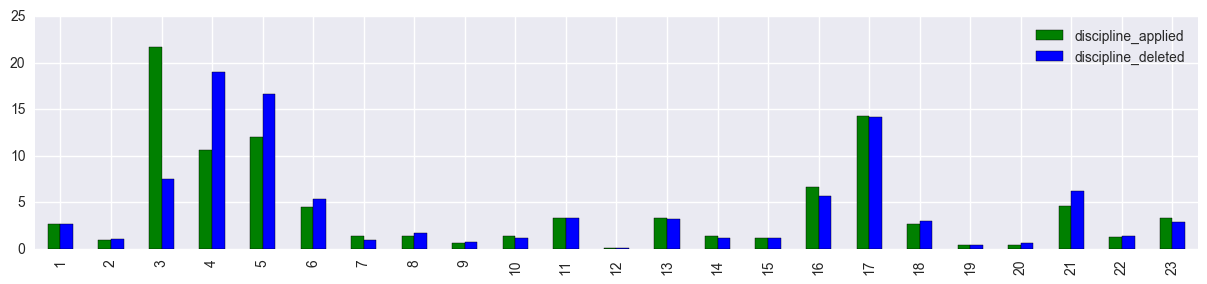

In [32]:
discipline_deleted = users_not_interested[users_not_interested.discipline_id!=0].discipline_id.value_counts()/len(users_not_interested[users_not_interested.discipline_id!=0])*100
discipline_applied = users_interested[users_interested.discipline_id!=0].discipline_id.value_counts()/len(users_interested[users_interested.discipline_id!=0])*100
df = pd.DataFrame({'discipline_deleted':discipline_deleted, 'discipline_applied':discipline_applied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

    2. items

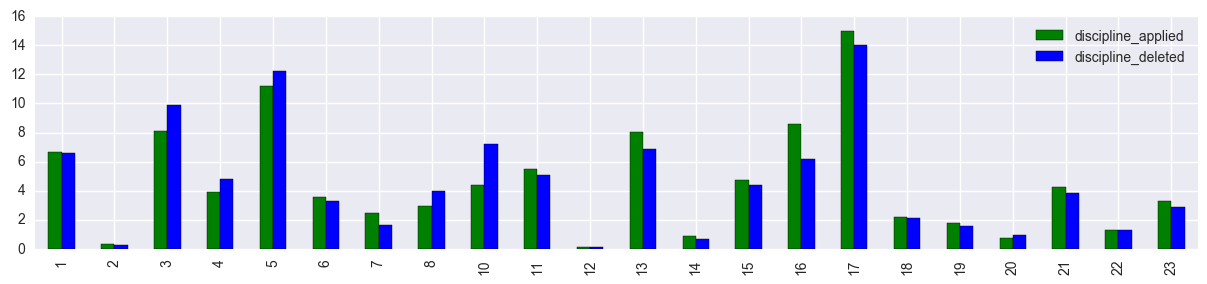

In [33]:
discipline_deleted = items_not_interesting[items_not_interesting.discipline_id!=0].discipline_id.value_counts()/len(items_not_interesting[items_not_interesting.discipline_id!=0])*100
discipline_applied = items_interesting[items_interesting.discipline_id!=0].discipline_id.value_counts()/len(items_interesting[items_interesting.discipline_id!=0])*100
df = pd.DataFrame({'discipline_deleted':discipline_deleted, 'discipline_applied':discipline_applied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

In [34]:
print subset1.shape

(329534, 29)


In [35]:
idx = subset1.discipline_id_item==subset1.discipline_id_user
subset1[idx].discipline_id_item.value_counts()/len(subset1[idx])*100

5     20.373403
17    18.839393
21    11.292172
4     10.064554
3      9.444945
16     7.266759
11     5.248935
1      4.166667
6      2.358336
13     2.260754
8      1.580413
23     1.550388
18     1.034502
14     0.943061
20     0.831150
7      0.812725
15     0.772464
19     0.388962
22     0.316628
2      0.293427
10     0.144666
12     0.015695
Name: discipline_id_item, dtype: float64

In [36]:
idx = subset2.discipline_id_item==subset2.discipline_id_user
subset2[idx].discipline_id_item.value_counts()/len(subset2[idx])*100

3     30.397245
17    25.358558
5     11.049255
16     6.699377
21     3.944140
1      3.882808
11     3.566711
4      3.175127
13     2.934516
7      1.731459
6      1.622948
23     1.405926
18     0.849217
8      0.849217
15     0.702963
14     0.518966
20     0.367994
22     0.273637
2      0.264201
19     0.254765
10     0.136818
12     0.014154
Name: discipline_id_item, dtype: float64

Conclusions

    1. Many users do not specify discipline, but when it matches with the item discipline it is more likely that the user will be interested than not
    
    2. There are disciplines that when there is a match, a reply is much more likely than a delete: 5, 21, 4

## industry_id

In [37]:
data_deleted.industry_id_user.value_counts().head(n=5)

0     292992
7     105104
14     95927
16     80003
15     66800
Name: industry_id_user, dtype: int64

In [38]:
data_deleted.industry_id_item.value_counts().head(n=5)

16    242230
7     120412
3      86291
20     73217
9      59437
Name: industry_id_item, dtype: int64

In [39]:
data_replied.industry_id_user.value_counts().head(n=5)

0     33541
16    12608
18    12230
7     10969
5      7424
Name: industry_id_user, dtype: int64

In [40]:
data_replied.industry_id_item.value_counts().head(n=5)

16    36113
7     21104
9      8823
3      7903
14     5726
Name: industry_id_item, dtype: int64

In [41]:
subset1 = data_deleted[data_deleted.industry_id_user!=0]
n = float(len(subset1))
print np.sum(subset1.industry_id_item==subset1.industry_id_user)/n*100.0

20.1107575022


Very few interactions of type delete have a match of industry_id

In [42]:
subset2 = data_replied[data_replied.industry_id_user!=0]
n = float(len(subset2))
print np.sum(subset2.industry_id_item==subset2.industry_id_user)/n*100.0

27.2352264006


similarly for interactions of type reply

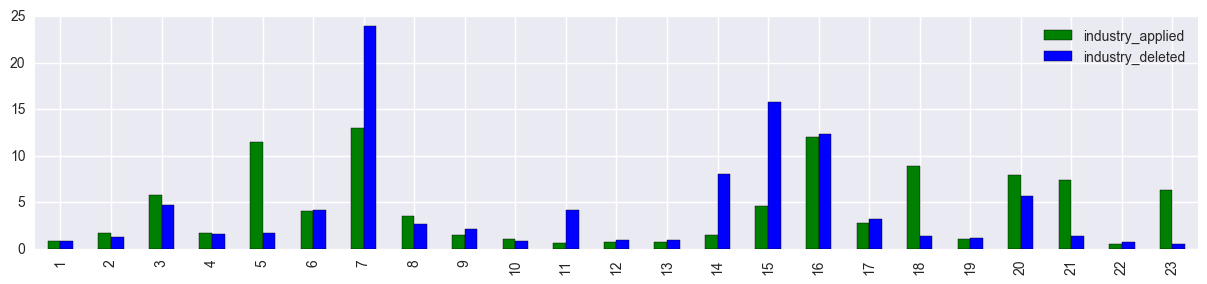

In [43]:
industry_deleted = users_not_interested[users_not_interested.industry_id!=0].industry_id.value_counts()/len(users_not_interested[users_not_interested.industry_id!=0])*100
industry_applied = users_interested[users_interested.industry_id!=0].industry_id.value_counts()/len(users_interested[users_interested.industry_id!=0])*100
df = pd.DataFrame({'industry_deleted':industry_deleted, 'industry_applied':industry_applied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

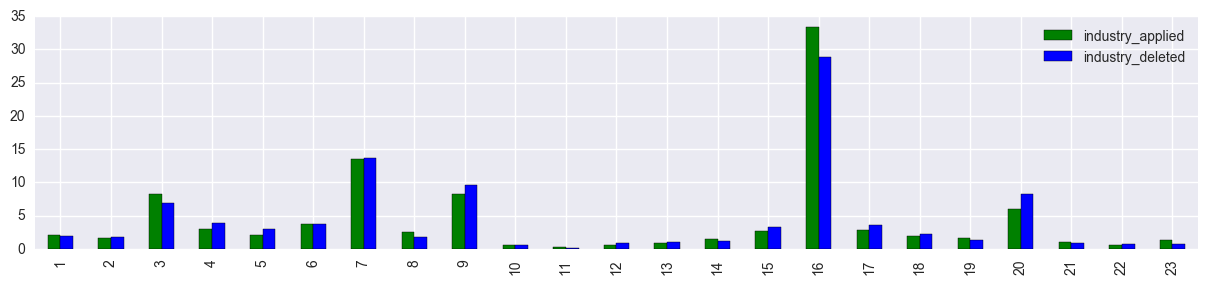

In [44]:
industry_deleted = items_not_interesting[items_not_interesting.industry_id!=0].industry_id.value_counts()/len(items_not_interesting[items_not_interesting.industry_id!=0])*100
industry_applied = items_interesting[items_interesting.industry_id!=0].industry_id.value_counts()/len(items_interesting[items_interesting.industry_id!=0])*100
df = pd.DataFrame({'industry_deleted':industry_deleted, 'industry_applied':industry_applied})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusions: 

    1. Industry_id match does not seem very relevant
    2. Usere from industries 18, 21 and 23 apply a lot more than delete

## experience_n_entries_class

In [45]:
data_deleted.experience_n_entries_class.value_counts()/float(len(data_deleted))*100

3    60.167842
2    20.357347
1    19.474811
Name: experience_n_entries_class, dtype: float64

In [46]:
data_replied.experience_n_entries_class.value_counts()/float(len(data_replied))*100

3    44.823959
1    34.030599
2    21.145442
Name: experience_n_entries_class, dtype: float64

Conclusions: 

    From the deleted interactions, 60% of them corresponded to users with more than 5 entries in CV (level=3). However, from the replied interactions, only 44% corresponded to them. 

## experience_years_experience & experience_years_in_current

In [47]:
data_deleted.experience_years_experience.value_counts()/float(len(data_deleted))*100

7    29.235206
4    18.028049
5    17.697471
6    16.863897
0    12.603741
3     3.325232
2     1.796240
1     0.450165
Name: experience_years_experience, dtype: float64

In [48]:
data_replied.experience_years_experience.value_counts()/float(len(data_replied))*100

0    23.080739
4    20.844415
5    17.802502
7    16.736080
6    12.827003
3     5.131999
2     2.895675
1     0.681587
Name: experience_years_experience, dtype: float64

Conclusion:
1. 30% of deletions occur with users with more than 7 years of experience
2. Less than 8% of the replies are done by users with 1, 2, or 3 years of experience 

In [49]:
data_deleted.experience_years_in_current.value_counts()/float(len(data_deleted))*100

2    28.204899
1    18.275734
4    15.002448
0    14.539020
3    13.544523
5     5.329147
6     2.687176
7     2.417054
Name: experience_years_in_current, dtype: float64

In [50]:
data_replied.experience_years_in_current.value_counts()/float(len(data_replied))*100

2    25.659993
0    25.402581
1    16.931918
4    12.570446
3    12.126602
5     3.730341
6     2.034498
7     1.543619
Name: experience_years_in_current, dtype: float64

Conclusion:
    1. 30% of deletions occur when user has 2 years of experience in current job
    2. At the same time 25% of replies happen when user has 2 years of experience at current job
    3. Don't know what to do here...

## edu_degree

In [51]:
data_deleted.edu_degree.value_counts()/float(len(data_deleted))*100

0    62.893148
2    24.735212
1     9.277625
3     3.094015
Name: edu_degree, dtype: float64

In [52]:
data_replied.edu_degree.value_counts()/float(len(data_replied))*100

0    67.164958
2    18.879187
1    11.088401
3     2.867454
Name: edu_degree, dtype: float64

Conclusion:
    1. Majority of users in both groups have not specifed the edu_degree 

## field of studies

In [53]:
# Count how many times each field of study appears
field_of_studies_deleted = data_deleted.edu_fieldofstudies.apply(lambda x: list(x))
field_of_studies_replied = data_replied.edu_fieldofstudies.apply(lambda x: list(x))

In [54]:
import itertools
field_of_studies_deleted = list(itertools.chain.from_iterable(field_of_studies_deleted.values.flatten()))
field_of_studies_replied = list(itertools.chain.from_iterable(field_of_studies_replied.values.flatten()))

In [55]:
from collections import Counter
{k: v/float(len(field_of_studies_deleted))*100 for k, v in dict(Counter(field_of_studies_deleted)).items()}

{'0': 43.77878659338213,
 '1': 0.3001376842768166,
 '2': 5.228492723190425,
 '3': 13.98773978173081,
 '4': 1.7318335474308795,
 '5': 8.76847280760603,
 '6': 0.8939951404369595,
 '7': 5.5047637957539495,
 '8': 18.841987988475836,
 '9': 0.9637899377161658}

In [56]:
{k: v/float(len(field_of_studies_replied))*100 for k, v in dict(Counter(field_of_studies_replied)).items()}

{'0': 48.85507647314547,
 '1': 0.30668300201557125,
 '2': 3.564004268268585,
 '3': 15.552306050665928,
 '4': 1.6875469311939295,
 '5': 8.895387898668142,
 '6': 0.5572461763427261,
 '7': 4.090424060388096,
 '8': 15.752282338062681,
 '9': 0.7390428012488638}

Conclusions: 
    1. the distribution of field of studied is very similar between the two groups

## WTCJ

In [57]:
data_deleted.wtcj.value_counts()/len(data_deleted)*100

1    77.556619
0    22.443381
Name: wtcj, dtype: float64

In [58]:
data_replied.wtcj.value_counts()/len(data_replied)*100

1    80.617106
0    19.382894
Name: wtcj, dtype: float64

Conclusion:
    1. There is not a lot of difference between both groups

## premium

In [59]:
data_deleted.premium.value_counts()/len(data_deleted)*100

0    71.575932
1    28.424068
Name: premium, dtype: float64

In [60]:
data_replied.premium.value_counts()/len(data_replied)*100

0    84.438097
1    15.561903
Name: premium, dtype: float64

Conclusion:
1. Not much difference, but it seems that users who reply normally are not premium

## employment

In [61]:
data_deleted.employment.value_counts()/float(len(data_deleted))*100

1    95.996481
2     2.033425
3     1.098721
4     0.842968
0     0.028405
Name: employment, dtype: float64

In [62]:
data_replied.employment.value_counts()/float(len(data_replied))*100

1    92.840344
2     4.789067
3     1.743734
4     0.608041
0     0.018814
Name: employment, dtype: float64

Conclusions: 
    1. Both groups have majority of jobs full time

## title & tag

In [63]:
data_deleted.title.head()

0    {3431606, 4330980, 579315, 3614810, 2714822}
1    {3431606, 4330980, 579315, 3614810, 2714822}
2    {3431606, 4330980, 579315, 3614810, 2714822}
3    {579315, 3431606, 4330980, 3614810, 2714822}
4    {579315, 3431606, 4330980, 3614810, 2714822}
Name: title, dtype: object

In [64]:
data_replied.tags.head()

0    {3671787, 3102059, 1786537, 4535088, 4502227, ...
1    {310589, 65768, 1786537, 4535088, 278133, 2739...
2    {1698419, 2994300, 1786537, 88816, 4502227, 27...
3    {1698419, 2994300, 1786537, 88816, 4502227, 27...
4    {4559688, 3121473, 310589, 2729530, 3561652, 3...
Name: tags, dtype: object

In [65]:
def intersect(x):
    return x[0]&x[1]

Find the intersection between titles and tags

In [66]:
data_deleted['title_tag_match'] = data_deleted[['title', 'tags']].apply(intersect, axis=1)
data_replied['title_tag_match'] = data_replied[['title', 'tags']].apply(intersect, axis=1)

In [67]:
# Count how many titles
data_deleted['num_titles'] = data_deleted.title.apply(len)
data_deleted.num_titles.value_counts()/float(len(data_deleted))*100

3     20.125688
1     19.989743
2     18.853886
4     12.183859
5      9.711322
6      6.452404
7      4.330229
8      2.819805
9      2.513542
10     1.022570
11     0.840979
12     0.604899
14     0.262053
13     0.131192
15     0.083556
17     0.045647
16     0.017463
18     0.007516
19     0.002321
22     0.001216
20     0.000111
Name: num_titles, dtype: float64

In [68]:
# Count how many titles
data_replied['num_titles'] = data_replied.title.apply(len)
data_replied.num_titles.value_counts()/float(len(data_replied))*100

2     25.256343
1     21.035978
3     15.325870
5     10.150257
4      9.827850
8      8.657094
6      4.490606
7      2.810156
9      1.063002
10     0.692704
11     0.301882
12     0.161631
13     0.085519
14     0.055587
15     0.040194
18     0.017959
17     0.011117
16     0.010262
22     0.003421
20     0.001710
19     0.000855
Name: num_titles, dtype: float64

Conclusions:

1. Not much to extract... at the moment

## is_payed

In [69]:
data_deleted.is_payed.value_counts()/float(len(data_deleted))*100

1    74.513003
0    25.486997
Name: is_payed, dtype: float64

In [70]:
data_replied.is_payed.value_counts()/float(len(data_replied))*100

0    61.985924
1    38.014076
Name: is_payed, dtype: float64

Conclusions:
    1. It seems that for deleted interactions, 75 % of the posted jobs were payed for, however, when the user replied to the posting only 38% of them were payed for.

## Geography

In [71]:
n = float(len(data_replied))
print np.sum(data_replied.country_item==data_replied.country_user)/n*100.0

72.1917679355


In [72]:
n = float(len(data_deleted))
print np.sum(data_deleted.country_item==data_deleted.country_user)/n*100.0

86.6813884938


In [73]:
n = float(len(data_replied))
print np.sum(data_replied.region_item==data_replied.region_user)/n*100.0

33.8715332712


In [74]:
n = float(len(data_deleted))
print np.sum(data_deleted.region_item==data_deleted.region_user)/n*100.0

21.376159261


# Conclusions

I still need to think but some of the conclusions I have extracted here I believe can be converted into features for our classification problem. I will revise this later

# Possible extra features:

- career level match
- career level item < career level user
- discipline match
- industry match
- user industry is 18, 21 and 23
- region and country match

Now we will need similar comparison but for interactions of type bookmark, clicked and showed